# 05. 백테스트 (Backtest)

**목표:** 학습된 PPO 모델을 Test 데이터(미래 데이터)로 최종 성과 평가

```
[ 입력 ]  data/processed/test.csv
          models/ppo_best.zip
[ 출력 ]  백테스트 성과 리포트 + 차트
```

> ⚠️ Test 데이터는 학습/튜닝에 절대 사용하지 않은 미래 데이터입니다.  
> 여기서 나온 성과가 실제 모델의 실력에 가장 가깝습니다.

## 1. 한글 폰트 설정 및 Import

OS: Windows
폰트: ['Malgun Gothic']


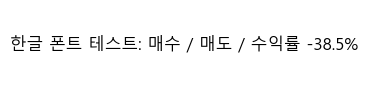

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# ─────────────────────────────────────────────
#  OS별 한글 폰트 자동 설정
# ─────────────────────────────────────────────
def set_korean_font():
    system = platform.system()
    
    if system == 'Windows':
        # Windows: 맑은 고딕
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif system == 'Darwin':
        # Mac: 애플 고딕
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        # Linux (Colab 등): NanumGothic 설치 필요
        import subprocess
        subprocess.run(['apt-get', 'install', '-y', 'fonts-nanum'], 
                      capture_output=True)
        fm._load_fontmanager(try_read_cache=False)
        plt.rcParams['font.family'] = 'NanumGothic'
    
    # 마이너스 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    
    print(f"OS: {system}")
    print(f"폰트: {plt.rcParams['font.family']}")

set_korean_font()

# 폰트 적용 테스트
fig, ax = plt.subplots(figsize=(4, 1))
ax.text(0.5, 0.5, '한글 폰트 테스트: 매수 / 매도 / 수익률 -38.5%', 
        ha='center', va='center', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.show()

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import torch
import warnings
warnings.filterwarnings('ignore')

sys.path.append('../src')
from env import BTCTradingEnv
from stable_baselines3 import PPO

PROCESSED_DIR = '../data/processed'
MODEL_DIR     = '../models'
REPORT_DIR    = '../models/reports'
os.makedirs(REPORT_DIR, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"디바이스: {device}")

디바이스: cuda


## 2. 데이터 및 모델 로드

In [3]:
def load_data(name):
    return pd.read_csv(
        os.path.join(PROCESSED_DIR, f'{name}.csv'), 
        index_col=0, parse_dates=True
    )

df_test  = load_data('test')
df_val   = load_data('val')
df_train = load_data('train')

# 최고 성과 모델 로드
best_model = PPO.load(os.path.join(MODEL_DIR, 'ppo_best'), device=device)

print(f"Test 데이터  : {len(df_test):,}행  ({df_test.index[0].date()} ~ {df_test.index[-1].date()})")
print(f"모델 로드    : ppo_best.zip ✅")

Test 데이터  : 16,380행  (2024-04-09 ~ 2026-02-20)
모델 로드    : ppo_best.zip ✅


## 3. 백테스트 실행 함수

In [4]:
def run_backtest(model, df, initial_balance=10_000.0, fee_rate=0.0005, label='Agent'):
    """
    학습된 모델로 전체 에피소드를 실행하고 상세 기록을 반환합니다.
    """
    env = BTCTradingEnv(df=df, initial_balance=initial_balance, fee_rate=fee_rate)
    obs, _ = env.reset()
    done   = False
    
    # 상세 기록
    records = []
    actions_taken = []
    
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        actions_taken.append(float(action[0]))
        records.append({
            'step'           : info['step'],
            'price'          : info['current_price'],
            'portfolio_value': info['portfolio_value'],
            'balance'        : info['balance'],
            'btc_held'       : info['btc_held'],
            'position_ratio' : info['position_ratio'],
            'action'         : float(action[0]),
            'reward'         : reward,
            'total_return'   : info['total_return'],
        })
    
    result_df = pd.DataFrame(records)
    result_df.index = df.index[1:len(result_df)+1]
    
    return env, result_df

print("백테스트 함수 정의 완료")

백테스트 함수 정의 완료


In [5]:
# Test 데이터로 백테스트 실행
print("백테스트 실행 중...")
test_env, test_result = run_backtest(best_model, df_test)
print(f"✅ 완료  ({len(test_result):,} 스텝)")

백테스트 실행 중...
✅ 완료  (16,379 스텝)


## 4. 성과 지표 계산

In [6]:
def compute_metrics(portfolio_values, initial_balance, trade_count, total_fees, prices):
    """
    포트폴리오 가치 배열로 주요 성과 지표를 계산합니다.
    """
    pv       = np.array(portfolio_values)
    returns  = np.diff(pv) / (pv[:-1] + 1e-9)
    
    # 수익률
    total_ret  = (pv[-1] - initial_balance) / initial_balance * 100
    
    # BnH
    bnh_ret    = (prices[-1] - prices[0]) / prices[0] * 100
    alpha      = total_ret - bnh_ret
    
    # 샤프 지수 (연환산, 1시간봉 기준)
    sharpe     = (np.mean(returns) / (np.std(returns) + 1e-9)) * np.sqrt(24 * 365)
    
    # 소르티노 지수 (하방 리스크만)
    downside   = returns[returns < 0]
    sortino    = (np.mean(returns) / (np.std(downside) + 1e-9)) * np.sqrt(24 * 365)
    
    # MDD
    roll_max   = np.maximum.accumulate(pv)
    drawdowns  = (roll_max - pv) / (roll_max + 1e-9)
    max_dd     = drawdowns.max() * 100
    
    # 칼마 비율
    calmar     = total_ret / (max_dd + 1e-9)
    
    # 승률
    win_rate   = (returns > 0).mean() * 100
    
    # Profit Factor
    gross_profit = returns[returns > 0].sum()
    gross_loss   = abs(returns[returns < 0].sum())
    profit_factor = gross_profit / (gross_loss + 1e-9)
    
    return {
        'total_return'  : total_ret,
        'bnh_return'    : bnh_ret,
        'alpha'         : alpha,
        'sharpe'        : sharpe,
        'sortino'       : sortino,
        'max_drawdown'  : max_dd,
        'calmar'        : calmar,
        'win_rate'      : win_rate,
        'profit_factor' : profit_factor,
        'trade_count'   : trade_count,
        'total_fees'    : total_fees,
        'final_value'   : pv[-1],
    }

# Test 지표 계산
prices     = df_test['close'].values[:len(test_env.portfolio_values)]
test_metrics = compute_metrics(
    portfolio_values=test_env.portfolio_values,
    initial_balance=10_000.0,
    trade_count=test_env.trade_count,
    total_fees=test_env.total_fees,
    prices=prices,
)

print("\n" + "=" * 50)
print("  📊 백테스트 성과 요약 (Test Set)")
print("=" * 50)
print(f"  기간             : {df_test.index[0].date()} ~ {df_test.index[-1].date()}")
print(f"  초기 자본        : $10,000.00")
print(f"  최종 자산        : ${test_metrics['final_value']:>12,.2f}")
print("-" * 50)
print(f"  총 수익률        : {test_metrics['total_return']:>+10.2f}%")
print(f"  Buy & Hold       : {test_metrics['bnh_return']:>+10.2f}%")
print(f"  알파 (초과수익)  : {test_metrics['alpha']:>+10.2f}%p")
print("-" * 50)
print(f"  샤프 지수        : {test_metrics['sharpe']:>10.3f}")
print(f"  소르티노 지수    : {test_metrics['sortino']:>10.3f}")
print(f"  최대 낙폭 (MDD)  : {test_metrics['max_drawdown']:>10.2f}%")
print(f"  칼마 비율        : {test_metrics['calmar']:>10.3f}")
print(f"  승률             : {test_metrics['win_rate']:>10.2f}%")
print(f"  Profit Factor    : {test_metrics['profit_factor']:>10.3f}")
print("-" * 50)
print(f"  총 거래 횟수     : {test_metrics['trade_count']:>10,}회")
print(f"  총 수수료        : ${test_metrics['total_fees']:>11,.2f}")
print("=" * 50)


  📊 백테스트 성과 요약 (Test Set)
  기간             : 2024-04-09 ~ 2026-02-20
  초기 자본        : $10,000.00
  최종 자산        : $   10,210.98
--------------------------------------------------
  총 수익률        :      +2.11%
  Buy & Hold       :      -5.18%
  알파 (초과수익)  :      +7.29%p
--------------------------------------------------
  샤프 지수        :      0.219
  소르티노 지수    :      0.282
  최대 낙폭 (MDD)  :      41.86%
  칼마 비율        :      0.050
  승률             :      50.42%
  Profit Factor    :      1.007
--------------------------------------------------
  총 거래 횟수     :         12회
  총 수수료        : $       3.52


## 5. 백테스트 시각화

차트 저장: ../models/reports\backtest_test.png


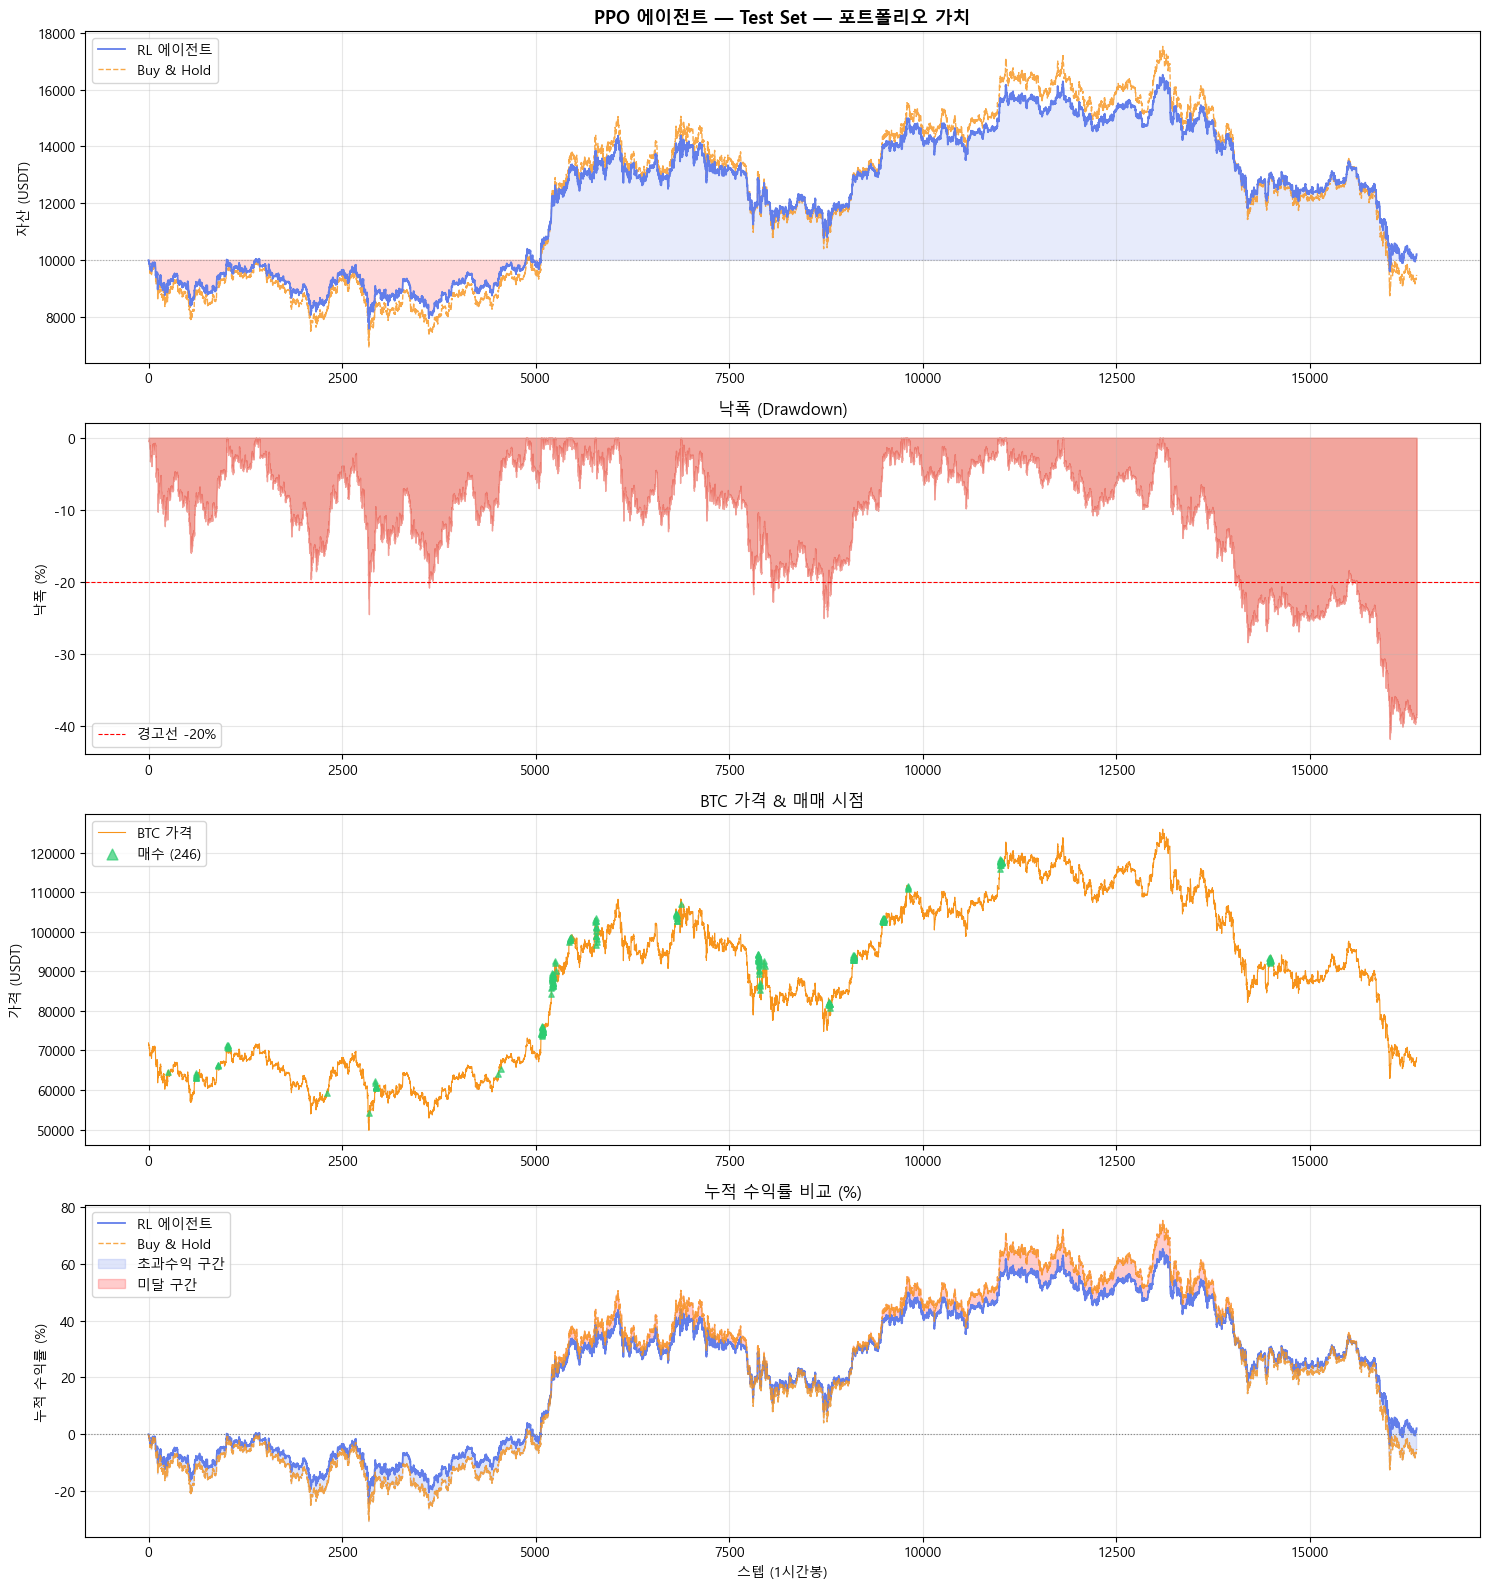

In [7]:
def plot_backtest(env, result_df, df, title='백테스트 결과', save_path=None):
    """
    백테스트 결과를 4개 패널로 시각화합니다.
    """
    pv         = np.array(env.portfolio_values)
    prices     = df['close'].values[:len(pv)]
    bnh        = 10_000.0 * (prices / prices[0])
    roll_max   = np.maximum.accumulate(pv)
    drawdown   = (roll_max - pv) / (roll_max + 1e-9) * 100
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 16), sharex=False)
    
    # ── 1) 포트폴리오 가치 vs BnH ──
    ax = axes[0]
    ax.plot(pv, color='#627EEA', linewidth=1.3, label='RL 에이전트', zorder=3)
    ax.plot(bnh, color='#F7931A', linewidth=1.0, linestyle='--', alpha=0.8, label='Buy & Hold')
    ax.axhline(10_000, color='gray', linestyle=':', linewidth=0.8, alpha=0.6)
    ax.fill_between(range(len(pv)), 10_000, pv, 
                    where=(pv >= 10_000), alpha=0.15, color='#627EEA')
    ax.fill_between(range(len(pv)), 10_000, pv,
                    where=(pv < 10_000), alpha=0.15, color='red')
    ax.set_title(f'{title} — 포트폴리오 가치', fontsize=13, fontweight='bold')
    ax.set_ylabel('자산 (USDT)')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)
    
    # ── 2) 낙폭 (Drawdown) ──
    ax = axes[1]
    ax.fill_between(range(len(drawdown)), 0, -drawdown, color='#E74C3C', alpha=0.5)
    ax.axhline(-20, color='red', linestyle='--', linewidth=0.8, label='경고선 -20%')
    ax.set_title('낙폭 (Drawdown)', fontsize=12)
    ax.set_ylabel('낙폭 (%)')
    ax.legend(loc='lower left')
    ax.grid(alpha=0.3)
    
    # ── 3) BTC 가격 + 매수/매도 시점 ──
    ax = axes[2]
    ax.plot(prices, color='#F7931A', linewidth=0.8, label='BTC 가격', zorder=2)
    
    if len(result_df) > 0:
        buy_idx  = result_df.index[result_df['action'] > 0.1]
        sell_idx = result_df.index[result_df['action'] < -0.1]
        
        # 인덱스를 정수 위치로 변환
        all_idx  = df.index[:len(prices)]
        buy_pos  = [all_idx.get_loc(i) for i in buy_idx if i in all_idx]
        sell_pos = [all_idx.get_loc(i) for i in sell_idx if i in all_idx]
        
        if buy_pos:
            ax.scatter(buy_pos, prices[buy_pos], marker='^', color='#2ECC71', 
                      s=15, alpha=0.7, zorder=3, label=f'매수 ({len(buy_pos)})')
        if sell_pos:
            ax.scatter(sell_pos, prices[sell_pos], marker='v', color='#E74C3C',
                      s=15, alpha=0.7, zorder=3, label=f'매도 ({len(sell_pos)})')
    
    ax.set_title('BTC 가격 & 매매 시점', fontsize=12)
    ax.set_ylabel('가격 (USDT)')
    ax.legend(loc='upper left', markerscale=2)
    ax.grid(alpha=0.3)
    
    # ── 4) 누적 수익률 비교 ──
    ax = axes[3]
    cum_ret_agent = (pv / pv[0] - 1) * 100
    cum_ret_bnh   = (bnh / bnh[0] - 1) * 100
    ax.plot(cum_ret_agent, color='#627EEA', linewidth=1.3, label='RL 에이전트')
    ax.plot(cum_ret_bnh, color='#F7931A', linewidth=1.0, linestyle='--', alpha=0.8, label='Buy & Hold')
    ax.axhline(0, color='gray', linestyle=':', linewidth=0.8)
    ax.fill_between(range(len(cum_ret_agent)), cum_ret_agent, cum_ret_bnh,
                    where=(cum_ret_agent >= cum_ret_bnh), alpha=0.2, color='#627EEA', label='초과수익 구간')
    ax.fill_between(range(len(cum_ret_agent)), cum_ret_agent, cum_ret_bnh,
                    where=(cum_ret_agent < cum_ret_bnh), alpha=0.2, color='red', label='미달 구간')
    ax.set_title('누적 수익률 비교 (%)', fontsize=12)
    ax.set_xlabel('스텝 (1시간봉)')
    ax.set_ylabel('누적 수익률 (%)')
    ax.legend(loc='upper left')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"차트 저장: {save_path}")
    plt.show()


plot_backtest(
    env=test_env,
    result_df=test_result,
    df=df_test,
    title='PPO 에이전트 — Test Set',
    save_path=os.path.join(REPORT_DIR, 'backtest_test.png')
)

## 6. Train / Val / Test 전 구간 비교

In [8]:
# 각 구간별 백테스트
print("Train 구간 백테스트...")
train_env, train_result = run_backtest(best_model, df_train)

print("Val 구간 백테스트...")
val_env, val_result = run_backtest(best_model, df_val)

print("✅ 전 구간 백테스트 완료")

Train 구간 백테스트...
Val 구간 백테스트...
✅ 전 구간 백테스트 완료


In [9]:
# 구간별 지표 계산
splits = {
    'Train' : (train_env, df_train),
    'Val'   : (val_env,   df_val),
    'Test'  : (test_env,  df_test),
}

all_metrics = {}
for split_name, (env, df) in splits.items():
    p = df['close'].values[:len(env.portfolio_values)]
    all_metrics[split_name] = compute_metrics(
        portfolio_values=env.portfolio_values,
        initial_balance=10_000.0,
        trade_count=env.trade_count,
        total_fees=env.total_fees,
        prices=p,
    )

# 비교 테이블 출력
metrics_df = pd.DataFrame(all_metrics).T
display_cols = ['total_return', 'bnh_return', 'alpha', 'sharpe', 
                'sortino', 'max_drawdown', 'calmar', 'win_rate', 'profit_factor']
display_names = ['총수익률(%)', 'BnH(%)', '알파(%p)', '샤프', 
                 '소르티노', 'MDD(%)', '칼마', '승률(%)', 'PF']

print("\n" + "=" * 75)
print("  📊 Train / Val / Test 전 구간 성과 비교")
print("=" * 75)
print(f"{'지표':<14}", end='')
for col in ['Train', 'Val', 'Test']:
    print(f"{col:>18}", end='')
print()
print("-" * 75)

for col, name in zip(display_cols, display_names):
    print(f"{name:<14}", end='')
    for split in ['Train', 'Val', 'Test']:
        val = all_metrics[split][col]
        print(f"{val:>+18.2f}", end='')
    print()

print("=" * 75)


  📊 Train / Val / Test 전 구간 성과 비교
지표                         Train               Val              Test
---------------------------------------------------------------------------
총수익률(%)                  +140.71           +109.20             +2.11
BnH(%)                    +99.79           +133.37             -5.18
알파(%p)                    +40.93            -24.17             +7.29
샤프                         +0.57             +3.11             +0.22
소르티노                       +0.70             +3.96             +0.28
MDD(%)                    +68.69            +16.67            +41.86
칼마                         +2.05             +6.55             +0.05
승률(%)                     +50.80            +51.52            +50.42
PF                         +1.02             +1.12             +1.01


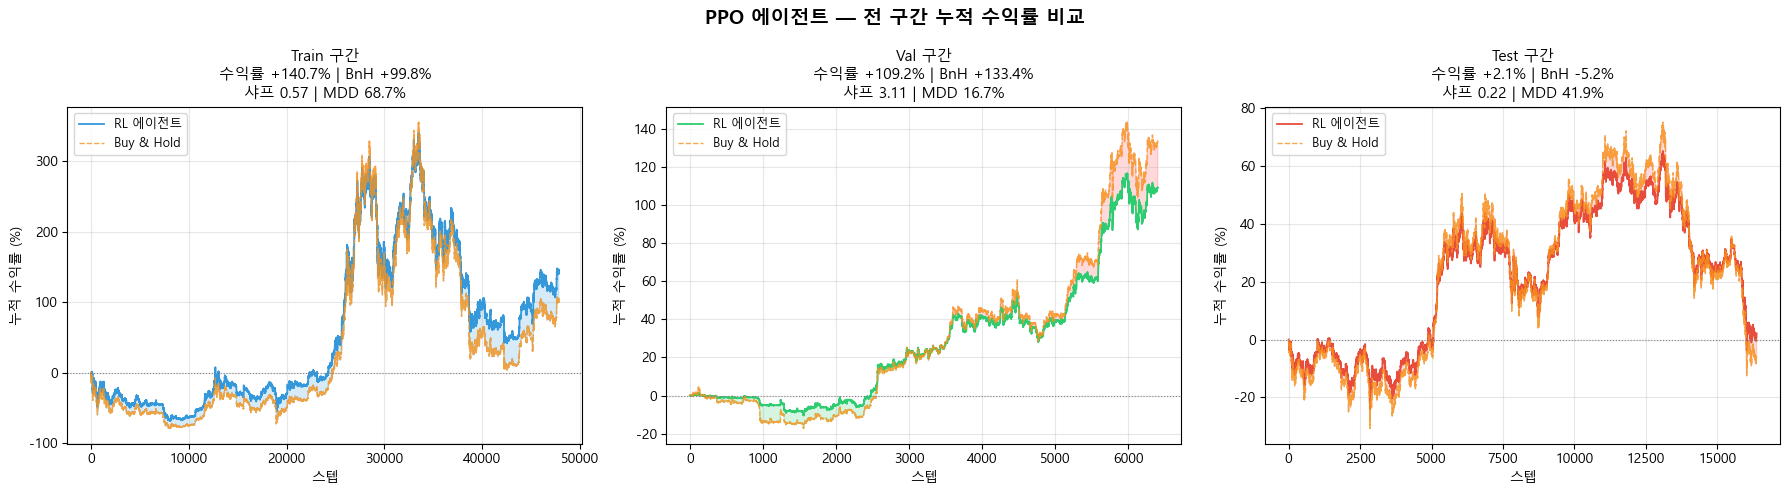

In [10]:
# 전 구간 비교 시각화
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

split_configs = [
    ('Train', train_env, df_train, '#3498DB'),
    ('Val',   val_env,   df_val,   '#2ECC71'),
    ('Test',  test_env,  df_test,  '#E74C3C'),
]

for ax, (name, env, df, color) in zip(axes, split_configs):
    pv    = np.array(env.portfolio_values)
    price = df['close'].values[:len(pv)]
    bnh   = 10_000.0 * (price / price[0])
    
    cum_agent = (pv / pv[0] - 1) * 100
    cum_bnh   = (bnh / bnh[0] - 1) * 100
    
    ax.plot(cum_agent, color=color, linewidth=1.3, label='RL 에이전트')
    ax.plot(cum_bnh, color='#F7931A', linewidth=1.0, linestyle='--', alpha=0.8, label='Buy & Hold')
    ax.axhline(0, color='gray', linestyle=':', linewidth=0.8)
    ax.fill_between(range(len(cum_agent)), cum_agent, cum_bnh,
                    where=(cum_agent >= cum_bnh), alpha=0.2, color=color)
    ax.fill_between(range(len(cum_agent)), cum_agent, cum_bnh,
                    where=(cum_agent < cum_bnh), alpha=0.15, color='red')
    
    m = all_metrics[name]
    ax.set_title(
        f'{name} 구간\n'
        f"수익률 {m['total_return']:+.1f}% | BnH {m['bnh_return']:+.1f}%\n"
        f"샤프 {m['sharpe']:.2f} | MDD {m['max_drawdown']:.1f}%",
        fontsize=11
    )
    ax.set_ylabel('누적 수익률 (%)')
    ax.set_xlabel('스텝')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('PPO 에이전트 — 전 구간 누적 수익률 비교', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(REPORT_DIR, 'all_splits_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. 월별 수익률 히트맵 (Test)

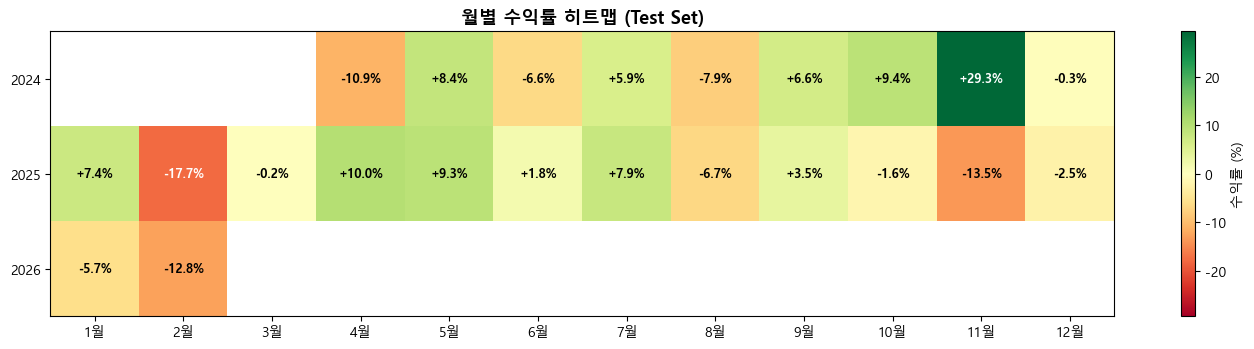

In [11]:
# Test 구간 월별 수익률
test_result['year']  = test_result.index.year
test_result['month'] = test_result.index.month

# 월별 수익률 계산
monthly = test_result.groupby(['year', 'month'])['portfolio_value'].agg(['first', 'last'])
monthly['return'] = (monthly['last'] / monthly['first'] - 1) * 100
monthly_pivot = monthly['return'].unstack(level='month')
monthly_pivot.columns = ['1월','2월','3월','4월','5월','6월',
                          '7월','8월','9월','10월','11월','12월']

fig, ax = plt.subplots(figsize=(14, max(3, len(monthly_pivot) * 1.2)))

# 히트맵 수동 구현
data = monthly_pivot.values
vmax = max(abs(np.nanmin(data)), abs(np.nanmax(data)))
im   = ax.imshow(data, cmap='RdYlGn', vmin=-vmax, vmax=vmax, aspect='auto')
plt.colorbar(im, ax=ax, label='수익률 (%)')

ax.set_xticks(range(len(monthly_pivot.columns)))
ax.set_xticklabels(monthly_pivot.columns, fontsize=10)
ax.set_yticks(range(len(monthly_pivot.index)))
ax.set_yticklabels([str(y) for y in monthly_pivot.index], fontsize=10)

for i in range(len(monthly_pivot.index)):
    for j in range(len(monthly_pivot.columns)):
        val = data[i, j]
        if not np.isnan(val):
            color = 'white' if abs(val) > vmax * 0.6 else 'black'
            ax.text(j, i, f'{val:+.1f}%', ha='center', va='center',
                    fontsize=9, color=color, fontweight='bold')

ax.set_title('월별 수익률 히트맵 (Test Set)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(REPORT_DIR, 'monthly_returns.png'), dpi=150, bbox_inches='tight')
plt.show()

## 8. 개선 방향 분석

In [12]:
print("=" * 55)
print("  🔍 모델 진단 및 개선 방향")
print("=" * 55)

m = all_metrics['Test']

# 진단
issues = []
goods  = []

if m['sharpe'] > 1.5:
    goods.append(f"✅ 샤프 지수 우수 ({m['sharpe']:.2f} > 1.5)")
elif m['sharpe'] > 0.5:
    issues.append(f"🔶 샤프 지수 개선 필요 ({m['sharpe']:.2f}, 목표: >1.5)")
else:
    issues.append(f"❌ 샤프 지수 부족 ({m['sharpe']:.2f}, 목표: >1.5)")

if m['max_drawdown'] < 15:
    goods.append(f"✅ MDD 양호 ({m['max_drawdown']:.1f}% < 15%)")
elif m['max_drawdown'] < 30:
    issues.append(f"🔶 MDD 주의 ({m['max_drawdown']:.1f}%, 목표: <15%)")
else:
    issues.append(f"❌ MDD 과대 ({m['max_drawdown']:.1f}%, 목표: <15%)")

if m['alpha'] > 0:
    goods.append(f"✅ Buy&Hold 초과 달성 (알파: {m['alpha']:+.1f}%p)")
else:
    issues.append(f"🔶 Buy&Hold 미달 (알파: {m['alpha']:+.1f}%p)")

if m['win_rate'] > 52:
    goods.append(f"✅ 승률 양호 ({m['win_rate']:.1f}%)")
else:
    issues.append(f"🔶 승률 개선 필요 ({m['win_rate']:.1f}%, 목표: >52%)")

print("\n[ 잘된 점 ]")
for g in goods:
    print(f"  {g}")

print("\n[ 개선 필요 ]")
for i in issues:
    print(f"  {i}")

print("\n[ 다음 시도할 것들 ]")
suggestions = [
    "1. total_timesteps 증가 (100만 → 300만)",
    "2. ent_coef 증가 (탐색 강화: 0.005 → 0.01)",
    "3. learning_rate 스케줄링 적용",
    "4. 보상 함수 조정 (Sharpe 기반 보상으로 변경)",
    "5. 신경망 크기 확대 [256,256] → [512,256,128]",
    "6. SAC 알고리즘으로 비교 실험",
]
for s in suggestions:
    print(f"  {s}")

print("=" * 55)

  🔍 모델 진단 및 개선 방향

[ 잘된 점 ]
  ✅ Buy&Hold 초과 달성 (알파: +7.3%p)

[ 개선 필요 ]
  ❌ 샤프 지수 부족 (0.22, 목표: >1.5)
  ❌ MDD 과대 (41.9%, 목표: <15%)
  🔶 승률 개선 필요 (50.4%, 목표: >52%)

[ 다음 시도할 것들 ]
  1. total_timesteps 증가 (100만 → 300만)
  2. ent_coef 증가 (탐색 강화: 0.005 → 0.01)
  3. learning_rate 스케줄링 적용
  4. 보상 함수 조정 (Sharpe 기반 보상으로 변경)
  5. 신경망 크기 확대 [256,256] → [512,256,128]
  6. SAC 알고리즘으로 비교 실험


In [13]:
import json
from datetime import datetime

# 실험 결과 저장
result = {
    'timestamp'   : datetime.now().strftime('%Y-%m-%d %H:%M'),
    'model'       : 'PPO',
    'split'       : 'Test',
    'period'      : f"{df_test.index[0].date()} ~ {df_test.index[-1].date()}",
    
    # 성과 지표
    'total_return'  : round(test_metrics['total_return'], 4),
    'bnh_return'    : round(test_metrics['bnh_return'], 4),
    'alpha'         : round(test_metrics['alpha'], 4),
    'sharpe'        : round(test_metrics['sharpe'], 4),
    'sortino'       : round(test_metrics['sortino'], 4),
    'max_drawdown'  : round(test_metrics['max_drawdown'], 4),
    'calmar'        : round(test_metrics['calmar'], 4),
    'win_rate'      : round(test_metrics['win_rate'], 4),
    'profit_factor' : round(test_metrics['profit_factor'], 4),
    'trade_count'   : test_metrics['trade_count'],
    'total_fees'    : round(test_metrics['total_fees'], 4),
    
    # 하이퍼파라미터 (04 노트북의 CONFIG 참고)
    'config' : {
        'learning_rate' : 3e-4,
        'n_steps'       : 2048,
        'batch_size'    : 128,
        'n_epochs'      : 10,
        'gamma'         : 0.99,
        'ent_coef'      : 0.005,
        'net_arch'      : [256, 256],
        'total_timesteps': 1_000_000,
    }
}

# 누적 저장 (실험할 때마다 append)
log_path = '../models/experiment_log.jsonl'
with open(log_path, 'a', encoding='utf-8') as f:
    f.write(json.dumps(result, ensure_ascii=False) + '\n')

# 지금까지 쌓인 실험 이력 출력
print("=" * 55)
print("  💾 실험 결과 저장 완료")
print("=" * 55)
print(f"  저장 경로 : {log_path}")
print(f"  타임스탬프: {result['timestamp']}")
print()

# 전체 실험 이력 출력
with open(log_path, 'r', encoding='utf-8') as f:
    logs = [json.loads(line) for line in f.readlines()]

print(f"  전체 실험 횟수: {len(logs)}회")
print()
print(f"{'#':<4} {'시간':<17} {'모델':<6} {'수익률':>8} {'BnH':>8} {'알파':>8} {'샤프':>7} {'MDD':>7}")
print("-" * 70)
for i, log in enumerate(logs, 1):
    print(f"{i:<4} {log['timestamp']:<17} {log['model']:<6} "
          f"{log['total_return']:>+7.2f}% "
          f"{log['bnh_return']:>+7.2f}% "
          f"{log['alpha']:>+7.2f}%p "
          f"{log['sharpe']:>6.3f} "
          f"{log['max_drawdown']:>6.2f}%")
print("=" * 70)
print("\n📌 새 대화 시작 시 experiment_log.jsonl 파일을 업로드하면")
print("   이전 실험 이력을 모두 파악할 수 있습니다.")

  💾 실험 결과 저장 완료
  저장 경로 : ../models/experiment_log.jsonl
  타임스탬프: 2026-02-21 15:28

  전체 실험 횟수: 3회

#    시간                모델          수익률      BnH       알파      샤프     MDD
----------------------------------------------------------------------
1    2026-02-20 22:38  PPO     -25.53%   -5.18%  -20.35%p -0.563  35.86%
2    2026-02-21 13:40  PPO      +1.95%   -5.18%   +7.13%p  0.166  29.22%
3    2026-02-21 15:28  PPO      +2.11%   -5.18%   +7.29%p  0.219  41.86%

📌 새 대화 시작 시 experiment_log.jsonl 파일을 업로드하면
   이전 실험 이력을 모두 파악할 수 있습니다.


---

## ✅ 완료 요약

| 항목 | 내용 | 상태 |
|---|---|---|
| Test 백테스트 | 미래 데이터 최종 평가 | ✅ |
| 전 구간 비교 | Train / Val / Test 성과 테이블 | ✅ |
| 매매 시점 시각화 | 가격 차트 위 매수/매도 마커 | ✅ |
| 월별 수익률 | 히트맵 | ✅ |
| 진단 & 개선방향 | 자동 분석 | ✅ |

**다음 단계:** `04_train_agent.ipynb`로 돌아가 하이퍼파라미터를 조정하거나,  
성과가 만족스러우면 `06_hyperparameter_tuning.ipynb`으로 체계적 튜닝 진행